In [1]:
import sys
import numpy as np 
import pandas as pd 
from tensorflow import keras
import matplotlib.pyplot as plt
import IPython 
from cond_rnn import ConditionalRecurrent

In [2]:
#load sequence data for inputs set: AIS + Vessel particulars
path_01 = 'dataset/data_seq'
x_train = np.load(path_01 + '/x_train.npy')
x_test = np.load(path_01 + '/x_test.npy')
x_valid = np.load(path_01 + '/x_valid.npy')
y_train_seq = np.load(path_01 + '/y_train.npy')
y_test_seq = np.load(path_01 + '/y_test.npy')
y_valid_seq = np.load(path_01 + '/y_valid.npy')

#removing variables

#0:'Max_Draught'
#1: 'Latitude'
#2: 'Longitude'
#3: 'Speed_over_Ground'
#4: 'COG_cos'
#5: 'COG_sin'
#6: 'TH_cos'
#7: 'TH_sin'
#8: 'Navigational_Status_0.0'
#9: 'Navigational_Status_1.0'
#10: 'Navigational_Status_2.0'
#11: 'Navigational_Status_3.0'
#12: 'Navigational_Status_4.0'
#13: 'Na13vigational_Status_5.0'
#14: 'Nav14igational_Status_8.0'
#15: 'Navi15gational_Status_15.0'
#16: 'GT'
#17: 'DWT'
#18: 'LOA'
#19: 'BEAM'
#20: 'VesselTypeB_Cargo'
#21: 'VesselTypeB_Tanker'
#22: 'Age'
#23: 'current_utotal' 
#24: 'current_vtotal'
#25: 'wind_u10'
#26: 'wind_v10'
#27: 'mwd' 
#28: 'mwp' 
#29: 'swh'
#30: 'sst'  
#31: 'Origin_Lat'
#32: 'Origin_Lon'
#33: 'acc_dist' 
#34: 'acc_time_hours'
#35: 'leg_distance'
#36: 'leg_speed'
#37: 'leg_elapsed_time_hours'
#38: 'remaining_distance'


x_train_seq= np.delete(x_train,[23,24,25,26,27,28,29,30,31,32,33,34,35,36,38],2)
x_test_seq= np.delete(x_test,[23,24,25,26,27,28,29,30,31,32,33,34,35,36,38],2)
x_valid_seq= np.delete(x_valid,[23,24,25,26,27,28,29,30,31,32,33,34,35,36,38],2)


print('x_train_seq shape:', x_train_seq.shape)
print('y_train_seq shape:', y_train_seq.shape)
print('x_valid_seq shape:', x_valid_seq.shape)
print('y_valid_seq shape:', y_valid_seq.shape)
print('x_test_seq shape:', x_test_seq.shape)
print('y_test_seq shape:', y_test_seq.shape)

n_features = x_train_seq.shape[2]
steps = x_train_seq.shape[1]
print('n_features = ', n_features)
print('steps = ', steps)

x_train_seq shape: (1417, 65, 24)
y_train_seq shape: (1417, 65, 1)
x_valid_seq shape: (709, 65, 24)
y_valid_seq shape: (709, 65, 1)
x_test_seq shape: (708, 65, 24)
y_test_seq shape: (708, 65, 1)
n_features =  24
steps =  65


In [3]:
#separate sequential and non-sequential data
x_train_nn_cc= np.delete(x_train,[16,17,18,19,20,21,22,31,32,23,24,25,26,27,28,29,30,33,34,35,36,38],2)
x_test_nn_cc= np.delete(x_test,[16,17,18,19,20,21,22,31,32,23,24,25,26,27,28,29,30,33,34,35,36,38],2)
x_valid_nn_cc= np.delete(x_valid,[16,17,18,19,20,21,22,31,32,23,24,25,26,27,28,29,30,33,34,35,36,38],2)

x_train_cc_split= np.delete(x_train,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,23,24,25,26,27,28,29,30,33,34,35,36,37,38,31,32],2)
x_test_cc_split= np.delete(x_test,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,23,24,25,26,27,28,29,30,33,34,35,36,37,38,31,32],2)
x_valid_cc_split= np.delete(x_valid,[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,23,24,25,26,27,28,29,30,33,34,35,36,37,38,31,32],2)


print('x_train_nn_cc shape:', x_train_nn_cc.shape)
print('x_valid_nn_cc shape:', x_valid_nn_cc.shape)
print('x_test_nn_cc shape:', x_test_nn_cc.shape)
print('')
print('x_train_cc shape:', x_train_cc_split.shape)
print('x_valid_cc shape:', x_valid_cc_split.shape)
print('x_test_cc shape:', x_test_cc_split.shape)

n_features_nn_cc = x_train_nn_cc.shape[2]
n_features_cc = x_train_cc_split.shape[2]
steps = x_train_seq.shape[1]
print('n_features_nn_cc = ', n_features_nn_cc)
print('n_features_cc = ', n_features_cc)
print('steps = ', steps)

x_train_nn_cc shape: (1417, 65, 17)
x_valid_nn_cc shape: (709, 65, 17)
x_test_nn_cc shape: (708, 65, 17)

x_train_cc shape: (1417, 65, 7)
x_valid_cc shape: (709, 65, 7)
x_test_cc shape: (708, 65, 7)
n_features_nn_cc =  17
n_features_cc =  7
steps =  65


In [4]:
#put non-sequential data into the right shape
def get_cc_data(data):
  X = []
  for i in range(data.shape[0]):
    x = data[i,0,:]
    x = x.reshape (1,n_features_cc) 
    X.append(x)
  X = np.array(X).reshape(data.shape[0],data.shape[2])
  return X  

x_train_cc = get_cc_data(x_train_cc_split)
x_valid_cc = get_cc_data(x_valid_cc_split)
x_test_cc = get_cc_data(x_test_cc_split)  

In [5]:
#load non sequence data and keep variables for task 1
path_02 = 'dataset/data_nn_seq'
x_train_nn_seq = np.load(path_02 + '/x_train.npy')
x_test_nn_seq = np.load(path_02 + '/x_test.npy')
x_valid_nn_seq = np.load(path_02 + '/x_valid.npy')
y_train_nn_seq = np.load(path_02 + '/y_train.npy')
y_test_nn_seq = np.load(path_02 + '/y_test.npy')
y_valid_nn_seq = np.load(path_02 + '/y_valid.npy')

#removing variables
x_train_nn_seq= np.delete(x_train_nn_seq,[23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38],1)
x_test_nn_seq= np.delete(x_test_nn_seq,[23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38],1)
x_valid_nn_seq= np.delete(x_valid_nn_seq,[23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38],1)

print('x_train_nn_seq shape:', x_train_nn_seq.shape)
print('y_train_nn_seq shape:', y_train_nn_seq.shape)
print('x_valid_nn_seq shape:', x_valid_nn_seq.shape)
print('y_valid_nn_seq shape:', y_valid_nn_seq.shape)
print('x_test_nn_seq shape:', x_test_nn_seq.shape)
print('y_test_nn_seq shape:', y_test_nn_seq.shape)

x_train_nn_seq shape: (77122, 23)
y_train_nn_seq shape: (77122, 1)
x_valid_nn_seq shape: (38835, 23)
y_valid_nn_seq shape: (38835, 1)
x_test_nn_seq shape: (39777, 23)
y_test_nn_seq shape: (39777, 1)


In [6]:
#load sequences length
train_seq_len = np.load(path_01 + '/train_sequence_length.npy')
valid_seq_len = np.load(path_01+ '/valid_sequence_length.npy')
test_seq_len = np.load(path_01 + '/test_sequence_length.npy')
#load remaining_time metrics
rem_dist_train_std = np.load(path_01 + '/remaining_distance_std_train.npy')
rem_dist_train_mean = np.load(path_01 + '/remaining_distance_mean_train.npy')

In [7]:
#get a list of remaining distances from sequence data
test_seq = np.load(path_01 + '/x_test.npy')

def get_distance_arr(x_data, seq_len):
  distance = []
  for i in range(x_data.shape[0]):
    z = seq_len[i]
    d = x_data[i,:z,-1]
    d = d.tolist()
    distance.extend(d)
  return distance

#get the list for tests 
distance_seq_test = get_distance_arr(test_seq, test_seq_len)
distance_seq_rev_test = [(item*rem_dist_train_std)+rem_dist_train_mean for item in distance_seq_test]
distance_seq_rev_test = [max(num, 0) for num in distance_seq_rev_test]


#load non sequence data and get unscaled remaining distance list 
test_nn_seq = np.load(path_02 + '/x_test.npy')

distance_nn_seq_test = test_nn_seq[:,-1]
distance_nn_seq_rev_test = [(item*rem_dist_train_std) + rem_dist_train_mean for item in distance_nn_seq_test]
distance_nn_seq_rev_test = [max(num, 0) for num in distance_nn_seq_rev_test]

In [8]:
#load the models
models_path = 'models_performance/best_models/'
lstm1 = keras.models.load_model(models_path + 'lstm1.h5', custom_objects={'ConditionalRecurrent': ConditionalRecurrent})
cnn1 = keras.models.load_model(models_path + 'cnn1.h5')
wavenet1 = keras.models.load_model(models_path + 'wavenet1.h5')
mlp1 = keras.models.load_model(models_path + 'mlp1.h5')

##1-Models' performance and architecture:

In [9]:
#MSE and MAE evaluation on train, validation and test sets
print('LSTM:')
print('Train set performance:', lstm1.evaluate([x_train_nn_cc, x_train_cc], y_train_seq, verbose=0))
print('Validation set performance:', lstm1.evaluate([x_valid_nn_cc, x_valid_cc], y_valid_seq, verbose=0))
print('Test set performance:', lstm1.evaluate([x_test_nn_cc, x_test_cc], y_test_seq, verbose=0))
print('1D-CNN:')
print('Train set performance:', cnn1.evaluate([x_train_nn_cc, x_train_cc], y_train_seq, verbose=0))
print('Validation set performance:', cnn1.evaluate([x_valid_nn_cc, x_valid_cc], y_valid_seq, verbose=0))
print('Test set performance:', cnn1.evaluate([x_test_nn_cc, x_test_cc], y_test_seq, verbose=0))
print('WAVENET:')
print('Train set performance:', wavenet1.evaluate([x_train_nn_cc, x_train_cc], y_train_seq, verbose=0))
print('Validation set performance:', wavenet1.evaluate([x_valid_nn_cc, x_valid_cc], y_valid_seq, verbose=0))
print('Test set performance:', wavenet1.evaluate([x_test_nn_cc, x_test_cc], y_test_seq, verbose=0))
print('MLP:')
print('Train set performance:', mlp1.evaluate(x_train_nn_seq, y_train_nn_seq, verbose=0))
print('Validation set performance:', mlp1.evaluate(x_valid_nn_seq, y_valid_nn_seq, verbose=0))
print('Test set performance:', mlp1.evaluate(x_test_nn_seq, y_test_nn_seq, verbose=0))

LSTM:
Train set performance: [69.97576141357422, 4.22430944442749]
Validation set performance: [97.55074310302734, 4.966466903686523]
Test set performance: [86.94209289550781, 4.873080253601074]
1D-CNN:
Train set performance: [64.38302612304688, 4.578840255737305]
Validation set performance: [99.5745849609375, 5.415156841278076]
Test set performance: [92.6898193359375, 5.400647163391113]
WAVENET:
Train set performance: [75.86133575439453, 4.465818881988525]
Validation set performance: [90.11172485351562, 4.810487747192383]
Test set performance: [82.34295654296875, 4.848857402801514]
MLP:
Train set performance: [1167.90673828125, 24.861919403076172]
Validation set performance: [1512.9990234375, 28.220170974731445]
Test set performance: [1475.5723876953125, 28.355186462402344]


In [10]:
print(lstm1.summary())
print(cnn1.summary())
print(wavenet1.summary())
print(mlp1.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 65, 17)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 7)]          0           []                               
                                                                                                  
 conditional_recurrent (Conditi  (None, 65, 89)      38804       ['input_1[0][0]',                
 onalRecurrent)                                                   'input_2[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 65, 89)       0           ['conditional_recurrent[0][0]

##2-Predictions vs true targets plots:

In [11]:
#plot y_true vs y_predictions from test set
def plot_y_true_y_pred(name, model, x_test, y_test):
  test_predictions = model.predict(x_test)

  plt.figure(figsize=[2, 2], dpi=150)
  a = plt.axes(aspect='equal')

  plt.scatter(y_test, test_predictions, s=0.1)
  plt.xticks(fontsize=5)
  plt.yticks(fontsize=5)
  plt.xlabel('True Values [hour]', fontsize=7)
  plt.ylabel('Predictions [hour]', fontsize=7)
  plt.title(name, fontsize=8)
  lims = [0, 200]
  plt.xlim(lims)
  plt.ylim(lims)
  _ = plt.plot(lims, lims)


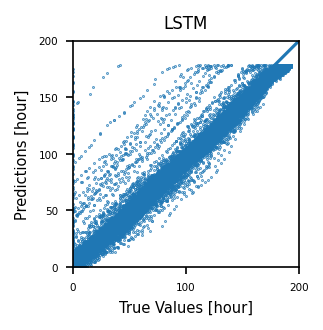

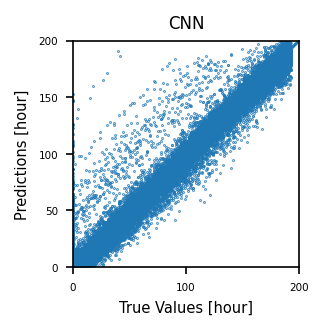

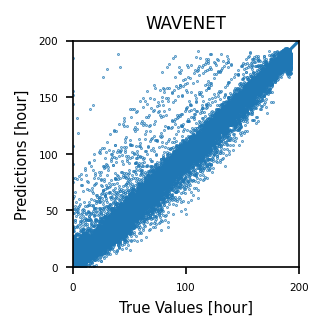

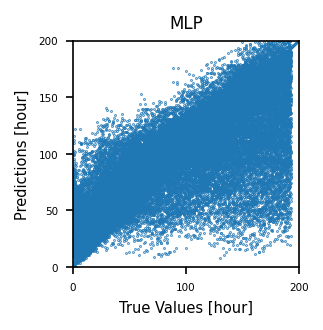

In [12]:
plot_y_true_y_pred('LSTM', lstm1, [x_test_nn_cc, x_test_cc], y_test_seq)
plot_y_true_y_pred('CNN', cnn1, [x_test_nn_cc, x_test_cc], y_test_seq)
plot_y_true_y_pred('WAVENET', wavenet1, [x_test_nn_cc, x_test_cc], y_test_seq)
plot_y_true_y_pred('MLP', mlp1, x_test_nn_seq, y_test_nn_seq)

##3-Error measures per observation for sequence models

In [13]:
#calculate the mse per obseravtion of sequence models for comparison with non sequence models 
def mse_obs(x_data_nn_cc, x_data_cc, y_data, model, seq_len):
  """
    Calculates the mse per observation of the sequence models
    
    Arguments:
    x_data_nn_cc -- sequential data
    x_data_cc -- non sequential data
    y_data -- true target
    model -- predictive model
    seq_len -- the true sequence length of the example

    Returns:
    squared error -- list of mse per observation
    MSE -- mean squared error
    """
    
  squared_error = []

  for i in range(x_data_nn_cc.shape[0]):
    y = y_data[i].reshape(1,steps,1)
    z = seq_len[i]
    y_hat = model.predict([x_data_nn_cc[i].reshape(1,steps,n_features_nn_cc), x_data_cc[i].reshape(1,n_features_cc)])
    error = np.square(y[:,:z,:] - y_hat[:,:z,:])
    error = error.reshape(z)
    error = error.tolist()
    squared_error.extend(error)
 
  return np.mean(squared_error), squared_error

In [14]:
#calculate the MAE per obseravtion of sequence models for comparison with non sequence models 
def mae_obs(x_data_nn_cc, x_data_cc, y_data, model, seq_len) :
  """
    Calculates the mse per observation of the sequence models
    
    Arguments:
    x_data_nn_cc -- sequential data
    x_data_cc -- non sequential data
    y_data -- true target
    model -- predictive model
    seq_len -- the true sequence length of the example

    Returns:
    absolute error -- list of mse per observation
    MAE -- mean absolute error
    """
  absolute_error =[]
  for i in range(x_data_nn_cc.shape[0]):
    y = y_data[i].reshape(1,steps,1)
    z = seq_len[i]
    y_hat = model.predict([x_data_nn_cc[i].reshape(1,steps,n_features_nn_cc),x_data_cc[i].reshape(1,n_features_cc)])
    error = np.abs(y[:,:z,:] - y_hat[:,:z,:])
    error = error.reshape(z)
    error = error.tolist()
    absolute_error.extend(error)
  return np.mean(absolute_error), absolute_error

In [15]:
#calculate MSE and MAE per observations for non sequence model
mlp1_pred = mlp1.predict(x_test_nn_seq)
mlp1_mse = np.square(y_test_nn_seq - mlp1_pred)
mlp1_mae = np.abs(y_test_nn_seq - mlp1_pred)

In [16]:
#calculate mse for sequence models
lstm1_mse_obs = mse_obs(x_test_nn_cc, x_test_cc, y_test_seq, lstm1, test_seq_len)
cnn1_mse_obs = mse_obs(x_test_nn_cc, x_test_cc, y_test_seq, cnn1, test_seq_len)
wavenet1_mse_obs = mse_obs(x_test_nn_cc, x_test_cc, y_test_seq, wavenet1, test_seq_len)

print('The performance metrics on the test set are:')
print('')
print('LSTM_1:')
print('The MSE considering errors per observation:', lstm1_mse_obs[0])
print('')
print('CNN_1:')
print('The MSE considering errors per observation:', cnn1_mse_obs[0])
print('')
print('WAVENET_1:')
print('The MSE considering errors per observation:', wavenet1_mse_obs[0])

The performance metrics on the test set are:

LSTM_1:
The MSE considering errors per observation: 82.0302427462923

CNN_1:
The MSE considering errors per observation: 93.41535677194935

WAVENET_1:
The MSE considering errors per observation: 89.92779236643426


In [17]:
#calculate mae for sequence models
lstm1_mae_obs = mae_obs(x_test_nn_cc, x_test_cc, y_test_seq, lstm1, test_seq_len)
cnn1_mae_obs = mae_obs(x_test_nn_cc, x_test_cc, y_test_seq, cnn1, test_seq_len)
wavenet1_mae_obs = mae_obs(x_test_nn_cc, x_test_cc, y_test_seq, wavenet1, test_seq_len)

print('The performance metrics on the test set are:')
print('')
print('LSTM_1:')
print('MAE considering errors per observation:', lstm1_mae_obs[0] )
print('')
print('CNN_1:')
print('MAE considering errors per observation:', cnn1_mae_obs[0] )
print('')
print('WAVENET_1:')
print('MAE considering errors per observation:', wavenet1_mae_obs[0] )

The performance metrics on the test set are:

LSTM_1:
MAE considering errors per observation: 5.458147321539127

CNN_1:
MAE considering errors per observation: 5.8405925162710846

WAVENET_1:
MAE considering errors per observation: 5.543803638968711
